In [1]:
import json
from argparse import Namespace
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import kornia
import torchvision
torch.set_printoptions(precision=4, sci_mode=False)

args = Namespace(
    file_hparams=Path("configs/wc14-test/extrem-pred.json"),
    per_sample_output=Path("experiments/wc14-test/extrem-pred/per_sample_output.json"),
    dir_images=Path("data/datasets/wc14-test"),
)

with open(args.file_hparams) as fr:
    hparams = json.load(fr)

df_cam = pd.read_json(args.per_sample_output, orient="records", lines=True).set_index("image_ids", drop=False)

In [2]:
sample = df_cam.iloc[0]

image_id = Path(sample.image_ids).stem
print(f"{image_id=}")
image_pil = Image.open(args.dir_images / sample.image_ids).convert("RGB")
image = torchvision.transforms.functional.to_tensor(image_pil)
sample

image_id='1'


batch_idx                                                                         0
image_ids                                                                     1.jpg
mask_lines                        [[[False, False, False, False], [True, True, T...
mask_circles                      [[[False, False, False, False, False, False, F...
loss_ndc_lines_distances_raw      [[[0.0, 0.0, 0.0, 0.0], [0.0027171311000000003...
loss_ndc_lines                                                             0.005286
loss_ndc_circles_distances_raw    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...
loss_ndc_circles                                                           0.003216
loss_ndc_total                                                             0.008502
loss_ndc_lines_distances_max                                               0.018874
loss_ndc_circles_distances_max                                             0.007408
loss_ndc_total_max                                                         0

torch.Size([24, 2]) torch.float32


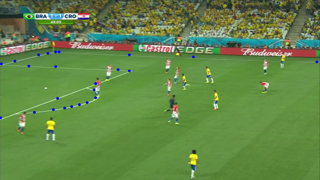

In [3]:
# load annotations from file
file_points_raw = (
    Path(hparams["dataset"]["extremities_annotations"])
    / f'{hparams["dataset"]["extremities_prefix"]}{image_id}.json'
)
if not file_points_raw.exists():
    raise FileNotFoundError(file_points_raw)
with open(file_points_raw) as fr:
    keypoints_raw = json.load(fr)

pixel_stacked = {}
for label, points in keypoints_raw.items():
    points_sel = points
    if len(points_sel) > 0:
        xx = torch.tensor([a["x"] for a in points_sel])
        yy = torch.tensor([a["y"] for a in points_sel])
        pixel_stacked[label] = torch.stack([xx, yy], dim=-1)  # (?, 2)
        # scale pixel annotations from [0, 1] range to source image resolution
        # as this ranges from [1, {image_height, image_width}] shift pixel one left
        pixel_stacked[label][:, 0] = pixel_stacked[label][:, 0] * (1280 - 1)
        pixel_stacked[label][:, 1] = pixel_stacked[label][:, 1] * (720 - 1)
pixels = torch.cat([x for x in pixel_stacked.values()])
print(pixels.shape, pixels.dtype)

torchvision.transforms.functional.to_pil_image(torchvision.utils.draw_keypoints((image * 255.).to(torch.uint8), pixels.unsqueeze(0), colors="blue", radius=5)).resize((320, 180))

/nfs/home/theinerj/miniconda3/envs/sn-calibration/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


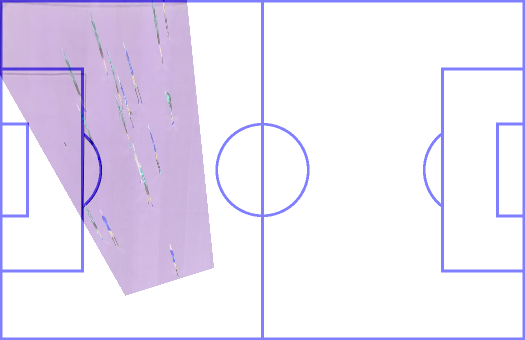

In [4]:
h = torch.tensor(sample.homography)

target_scale = 5
S = torch.eye(3).unsqueeze(0)
S[:, 0, 0] = S[:, 1, 1] = target_scale
# translate center of the homography matrix to the correct image origin (upper left)
T = torch.eye(3).unsqueeze(0)
T[:, 0, -1] = 105 / 2
T[:, 1, -1] = 68 / 2


def _warp_img(image, H):
    # scaling matrix for better image resolution
    warped_top = kornia.geometry.transform.homography_warp(
        image.unsqueeze(0),
        S @ T @ H,
        dsize=(int(68 * target_scale), int(105 * target_scale)),
        normalized_homography=False,
        normalized_coordinates=False,
        mode="nearest",
    ).squeeze()
    return warped_top

# image_mask = torch.ones(3, 720, 1280, dtype=torch.float)
# mask = _warp_img(image_mask, h)
mask = _warp_img(image, h)
mask = torch.permute(mask, (1, 2, 0))
mask = (mask * 255).to(torch.uint8)
mask = 255 - mask

# overlay with template
ftemplate = Path("template_pitch_t.png") 
template = torchvision.transforms.functional.to_tensor(Image.open(ftemplate).convert("RGB"))
template = torchvision.transforms.functional.resize(template, (int(target_scale*68), int(target_scale*105)))
template = torch.permute(template, (1, 2, 0))
template = (template * 255).to(torch.uint8)

background = Image.fromarray(template.numpy()) # [:, :, :3]
foreground = Image.fromarray(mask.numpy())
blended = Image.blend(background, foreground, alpha=0.5)
blended

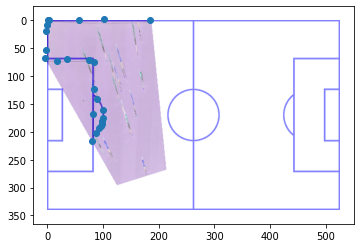

In [5]:
points_image = kornia.geometry.conversions.convert_points_to_homogeneous(pixels) # (?, 3)
points_image = points_image.transpose(0, 1) # (3, ?)

h_img2img = (S @ T @ h).squeeze(0)
projected_points = h_img2img @ points_image
projected_points = projected_points / (projected_points[-1] + 1e-8)

# plt.imshow(template)
plt.imshow(blended)
plt.scatter(projected_points[0], projected_points[1])
delta_m = 25
plt.xlim(0-delta_m, 105*target_scale+delta_m)
plt.ylim(0-delta_m, 68*target_scale+delta_m)
plt.gca().invert_yaxis() # 'image-style' coordinate system (upper left origin)
plt.show()

